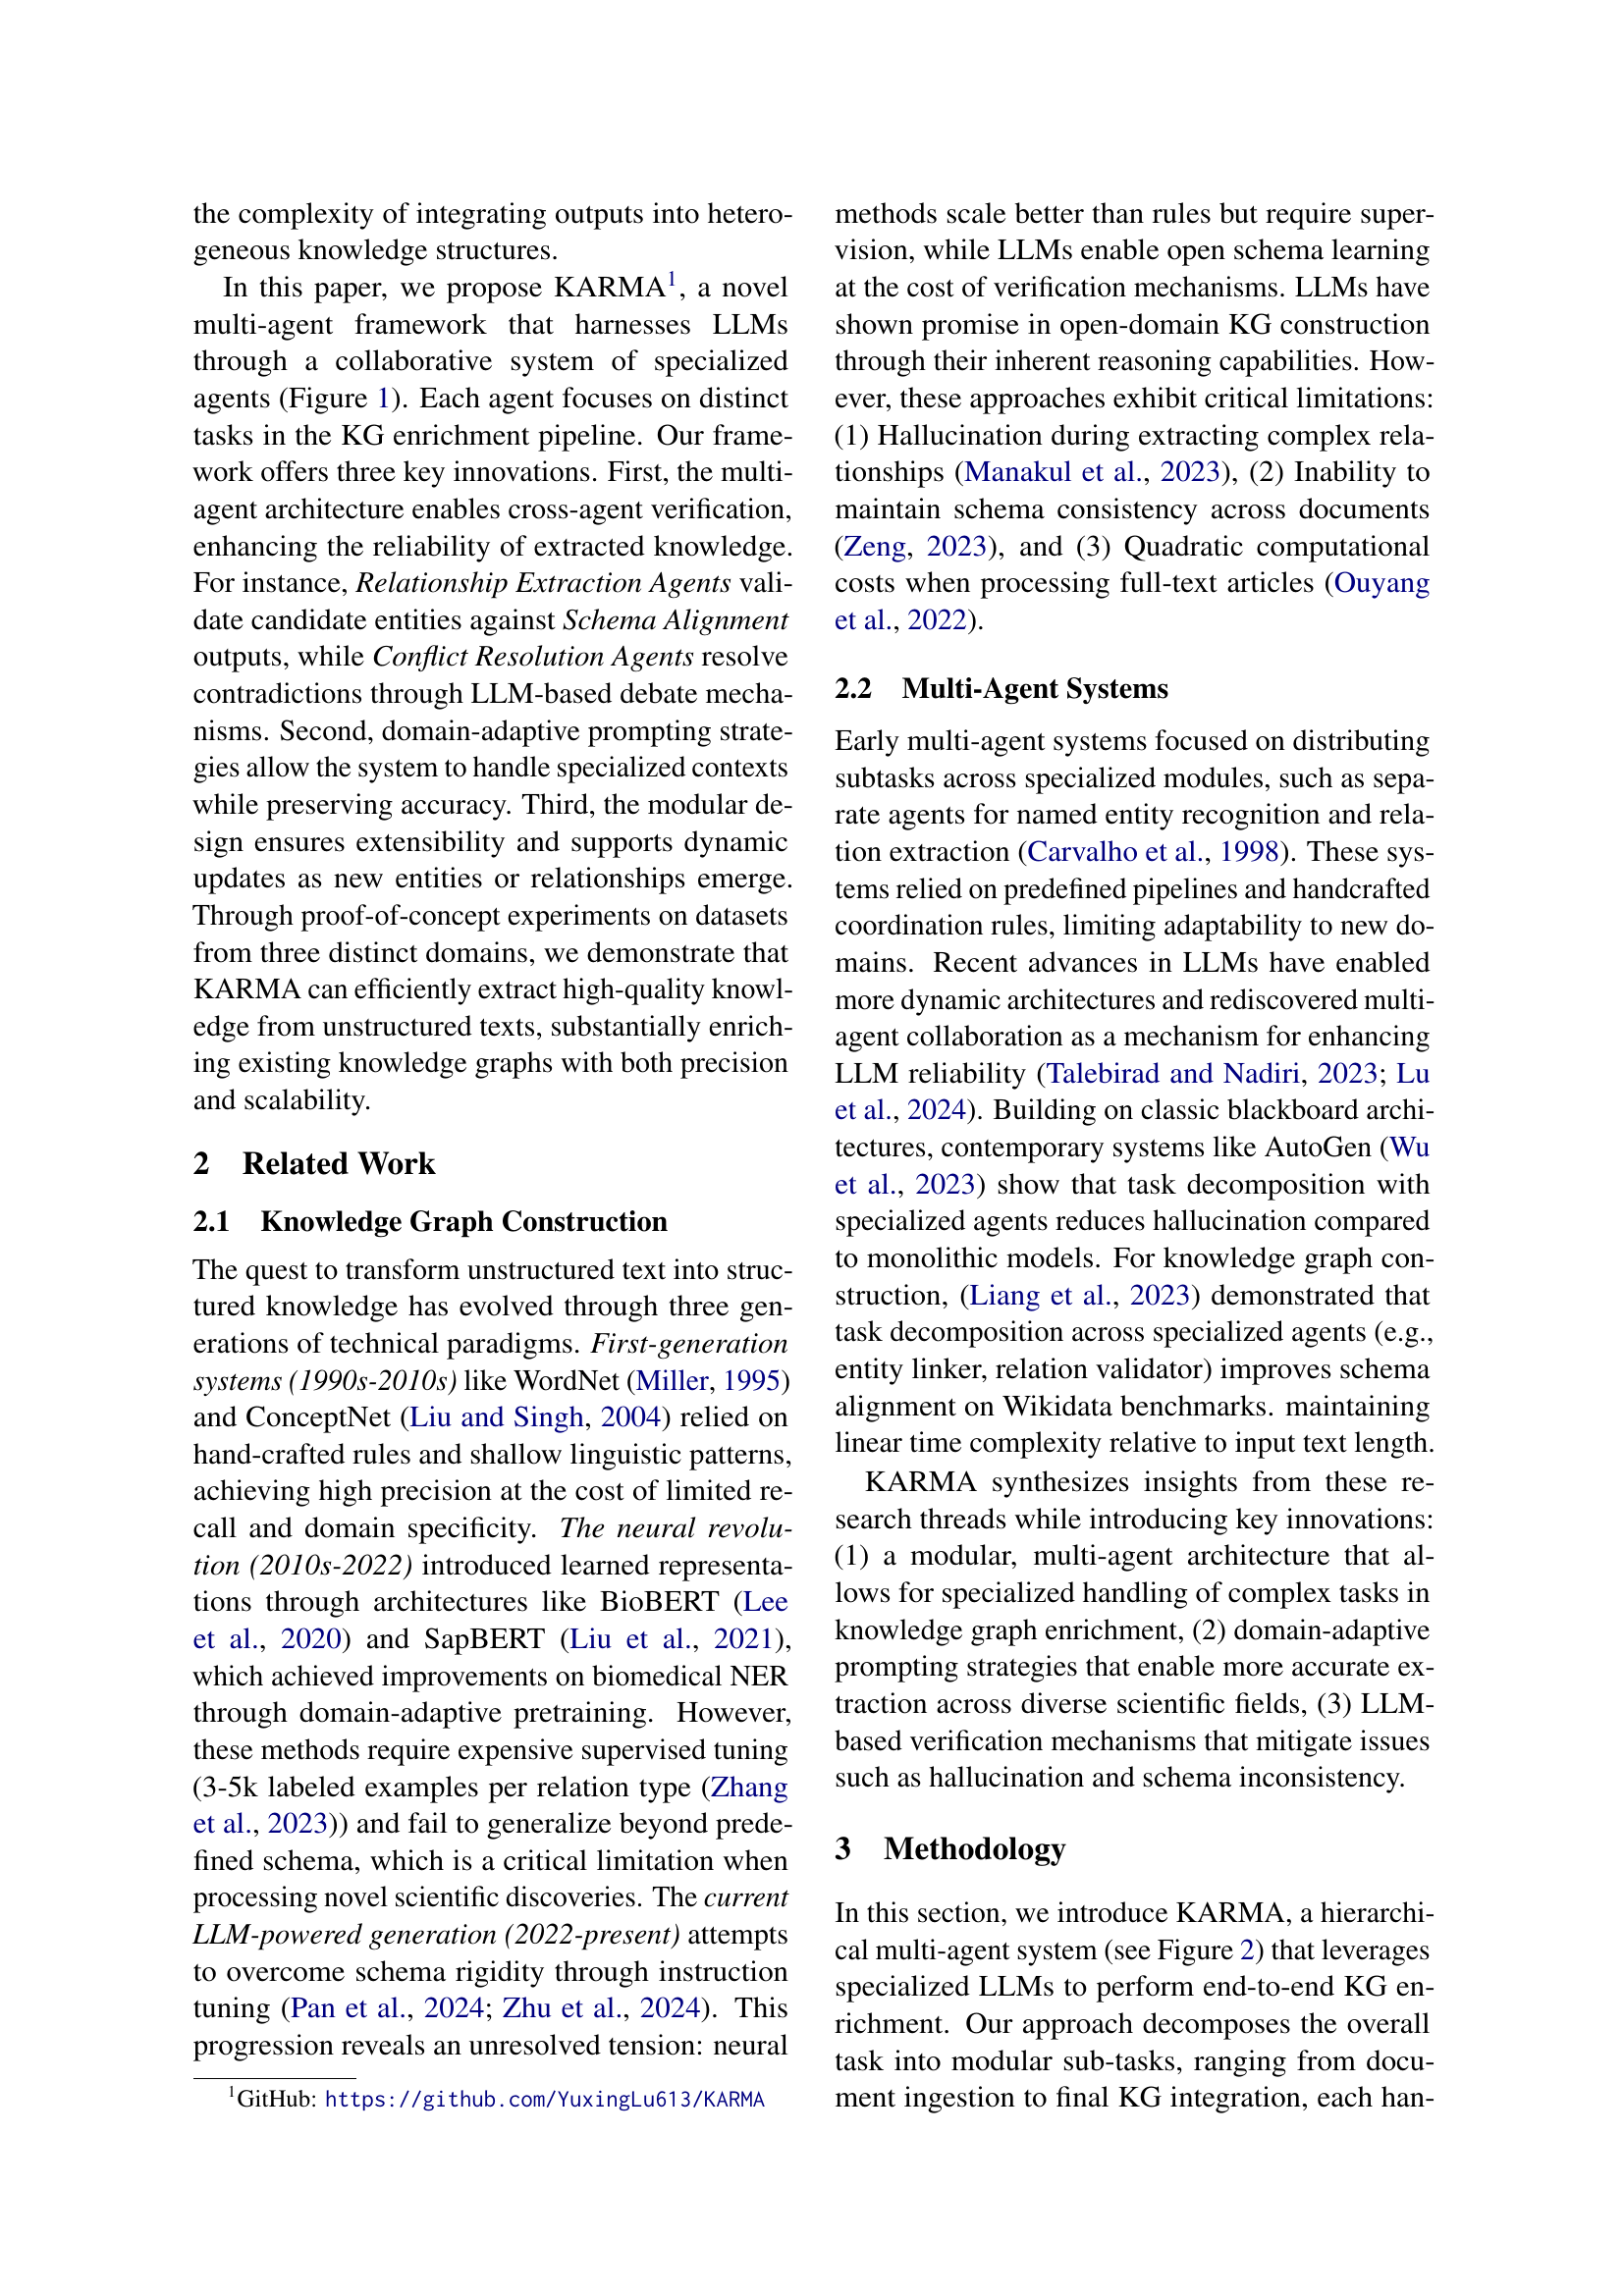

In [1]:
from pdf2image import convert_from_path

images = convert_from_path("./data/2502.06472v1.pdf")
images[1]

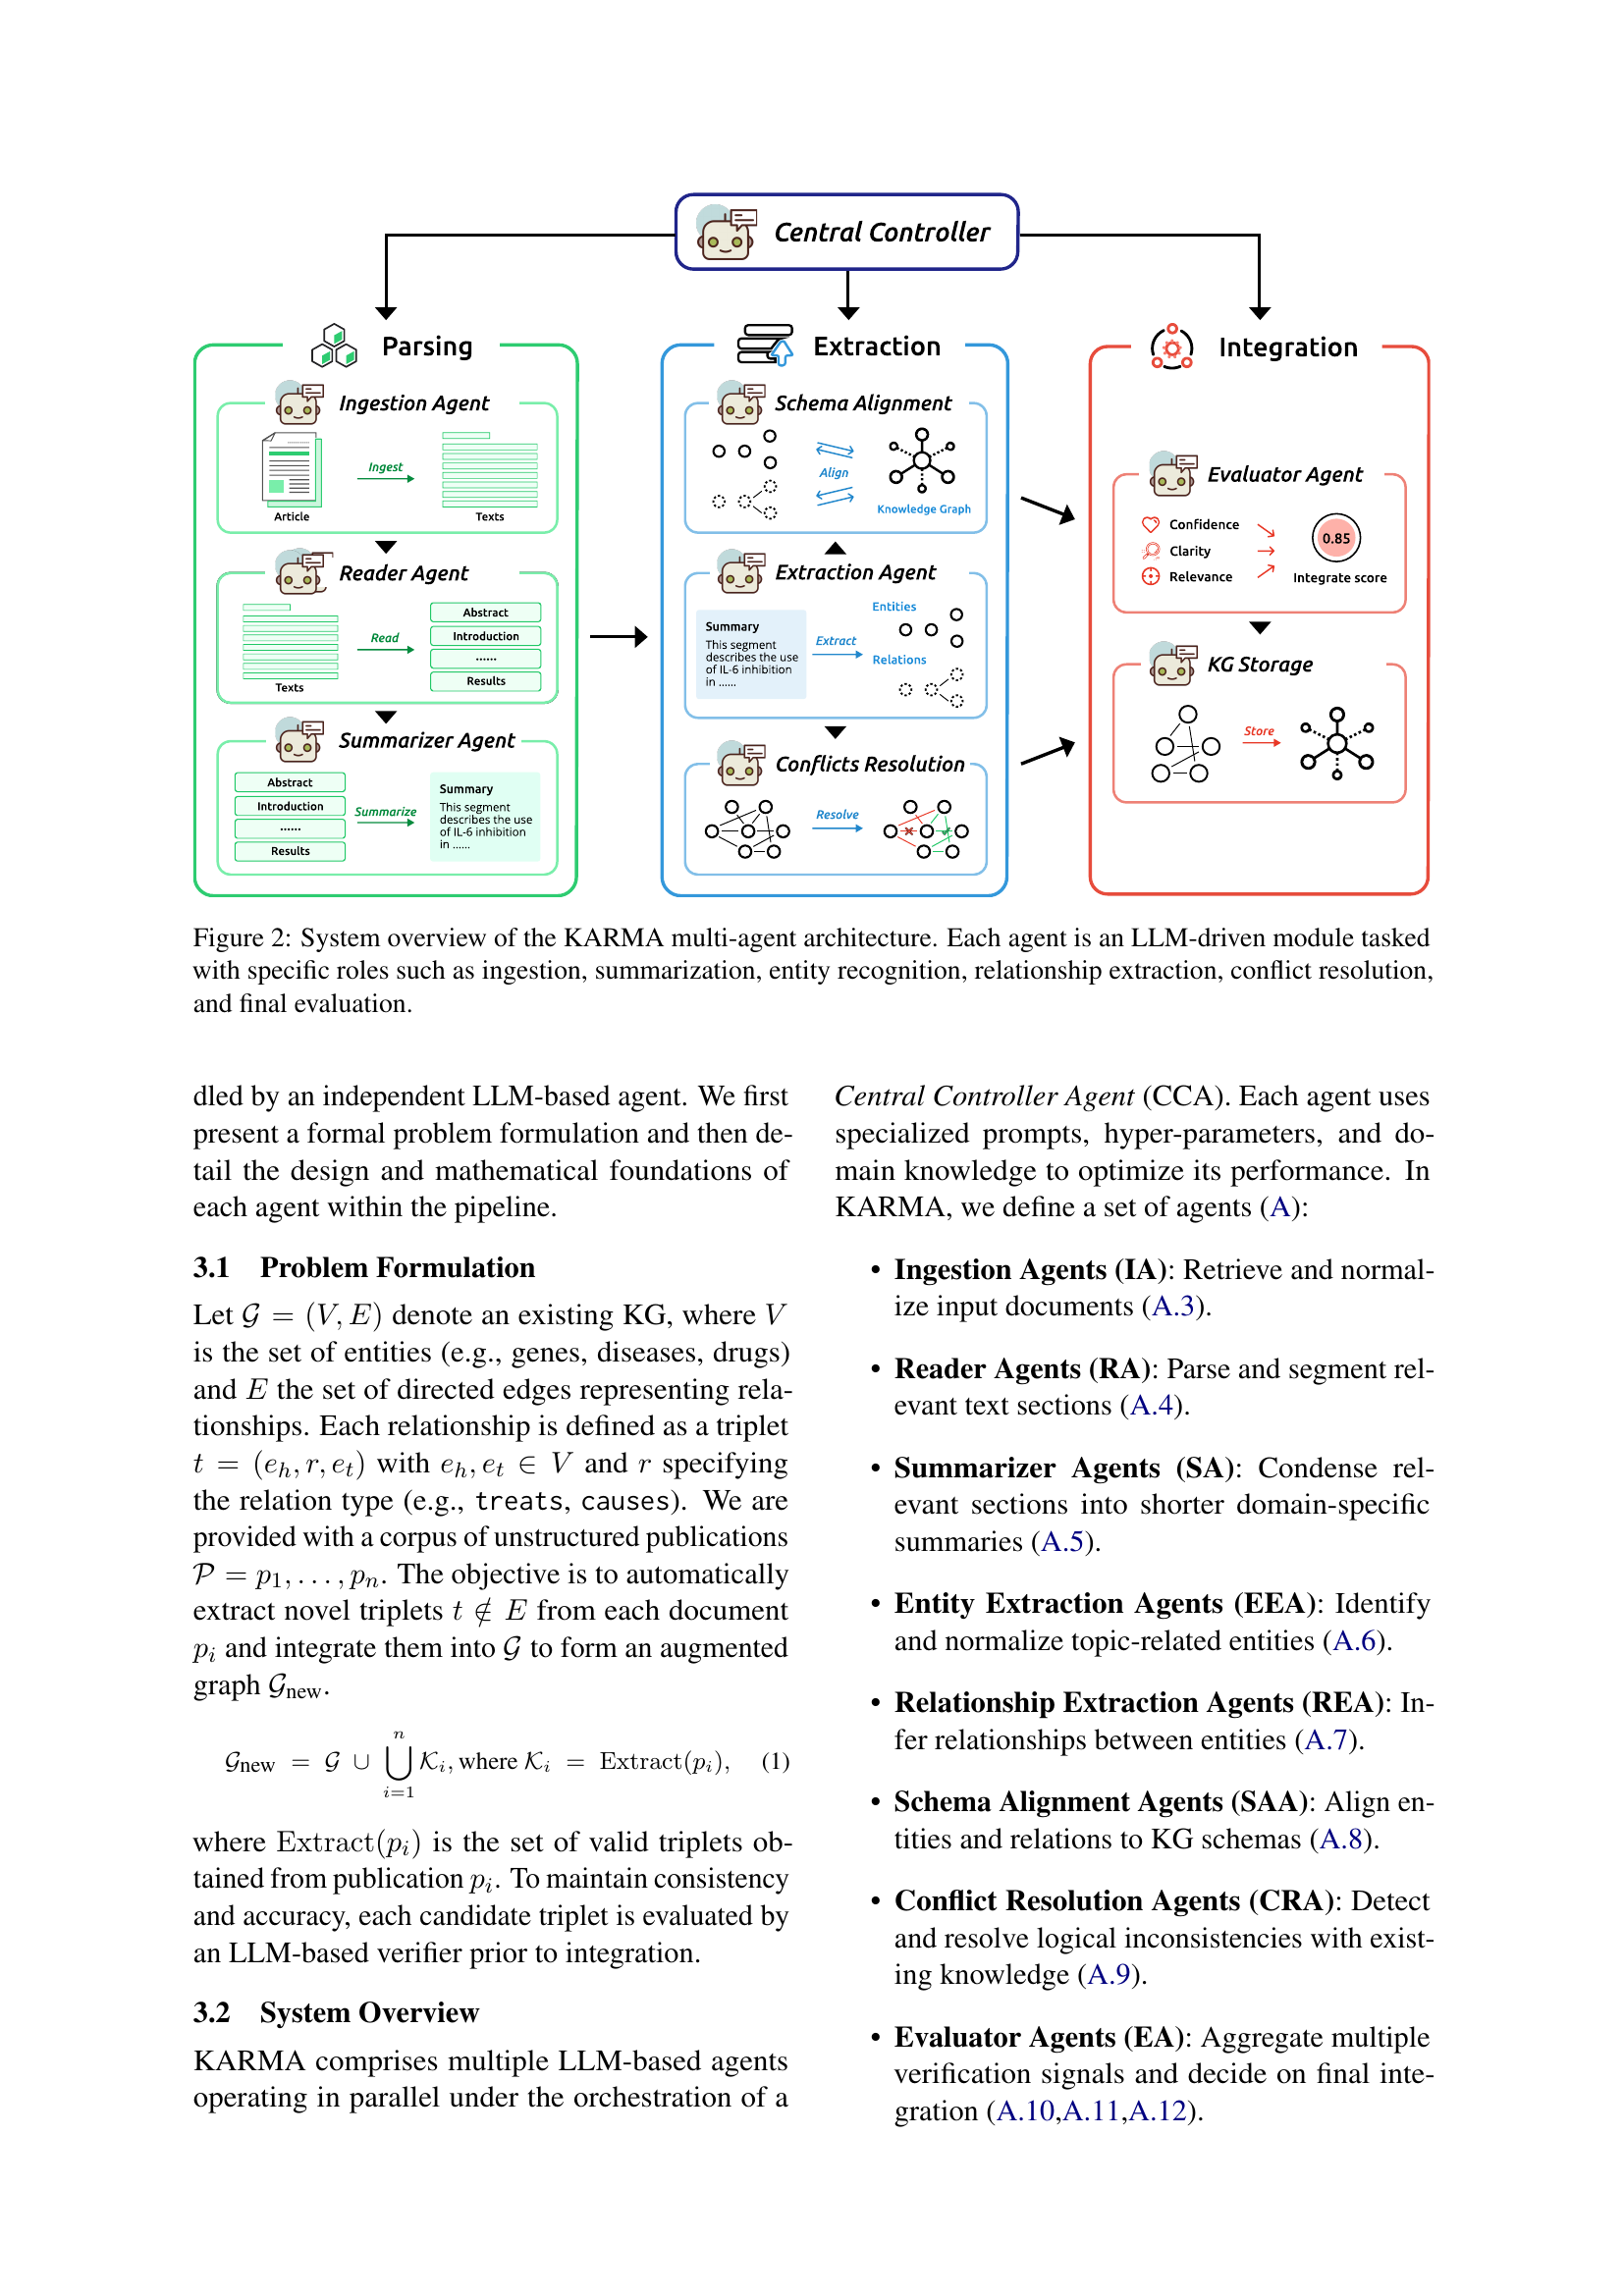

In [2]:
images[2]

In [3]:
len(images)

24

In [4]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.3", device="cuda")

/home/stanley/anaconda3/envs/llm_p11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.98s/it]


In [7]:
RAG.index(
    input_path="./data/2502.06472v1.pdf",
    index_name="agents_document_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)
  

overwrite is on. Deleting existing index agents_document_index to build a new one.
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Index exported

{0: 'data/2502.06472v1.pdf'}

In [13]:
text_query =  "Integration"
results = RAG.search(text_query, k=5)
results


[{'doc_id': 0, 'page_num': 3, 'score': 9.0625, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 12, 'score': 8.4375, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 11, 'score': 7.96875, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 18, 'score': 7.4375, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 5, 'score': 7.4375, 'metadata': {}, 'base64': None}]

In [18]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-2B-Instruct",
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).eval()



The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


In [19]:

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

image_index = results[0]["page_num"] - 1
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[image_index],
            },
            {"type": "text", "text": text_query},
        ],
    }
]
   

In [20]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
  

In [23]:

image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
# inputs = inputs.to("cuda")

In [ ]:
generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


In [ ]:
print(output_text)
